In [1]:
# Imports
import torch
import numpy as np
import random

# Assume the following modules are defined in your repository:
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.regression_functionals import NWFunctional 
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor  
from causal_cocycle.conditioners_new import NWConditioner  # NWConditioner defined earlier
from causal_cocycle.transformers_new import KREpsLayer  # Your KR transformer layer
from causal_cocycle.model_new import CocycleModel   # Your CocycleModel class
from causal_cocycle.helper_functions import kolmogorov_distance

# Import the DGP and policy functions from BD.py
from BD import DGP, policy, new_policy

# Import configs 
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

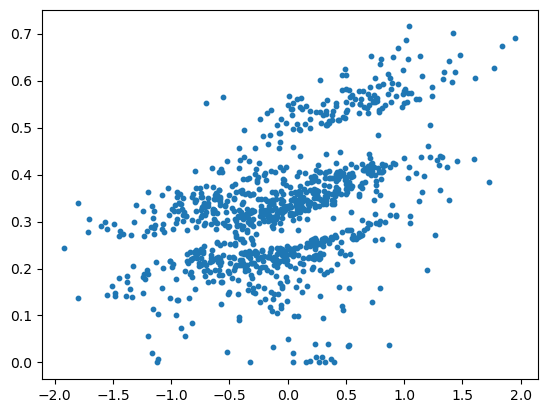

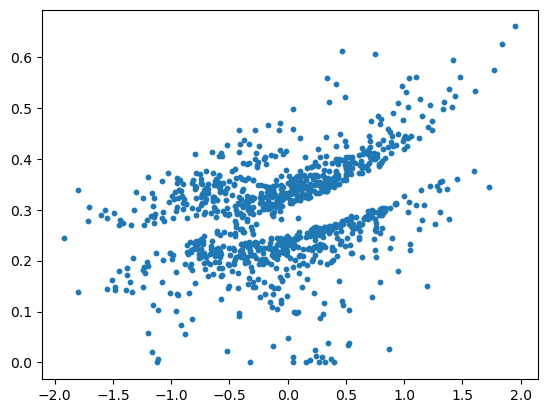

In [2]:
# -----------------------------
# 1. Load observational and interventional data.
def feature(y):
    return torch.log(1+torch.exp(-y))
    #return y

# Generating observatioanl data with configs
seed = 0
dgp_config['N'] = 1000
N = int(dgp_config['N']/2)
D = int(dgp_config['D'])+1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
Z1,X1,Y1 = Z[:N], X[:N],Y[:N]
Z2,X2,Y2 = Z[N:], X[N:],Y[N:]
plt.scatter(Z @ dgp_config['projection_coeffs'],feature(Y), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
Zint1,Xint1,Yint1 = Zint[:N], Xint[:N],Yint[:N]
Zint2,Xint2,Yint2 = Zint[N:], Xint[N:],Yint[N:]
plt.scatter(Zint @ dgp_config['projection_coeffs'],feature(Yint), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Z_train,X_train,Y_train = Z[id],X[id],feature(Y[id].double()).squeeze(-1)
Z_test,X_test,Y_test = Zint[id],Xint[id],feature(Yint[id].double()).squeeze(-1)

In [3]:
# -----------------------------
# 2. Determine a suitable epsilon.
# We choose epsilon to be a fraction (e.g., 1/10) of the smallest gap between successive Y_train values.
sorted_Y_train, ids = torch.sort(Y_train,0)
sorted_X_train = X_train[ids]

gaps = sorted_Y_train[1:] - sorted_Y_train[:-1]
min_gap = gaps[gaps!=0].abs().min()
epsilon = min(min_gap / 10, 1e-6)
print("Selected epsilon:", epsilon.item())

# -----------------------------------------------------------------------------
# 2. Instantiate ConditionalExpectationRegressor with NWFunctional
kernel = GaussianKernel(lengthscale=torch.ones(D)/D**0.5)
functional = NWFunctional(kernel=kernel, reg=0.0)
CER = ConditionalExpectationRegressor(functional)

# -----------------------------------------------------------------------------
# 3. Optimize the kernel hyperparameters (i.e. the lengthscale) using your optimise module
# -----------------------------------------------------------------------------
# Here we optimize the NWFunctional’s kernel lengthscale via CV loss.
# The optimiser will use your NWFunctional’s hyperparameter list, which in this case is [kernel.log_lengthscale].
print("Starting hyperparameter optimisation...")
test_points = Y_train.quantile(torch.linspace(0,1,100).double())[:,None]
feature = (Y_train.unsqueeze(-1) <= test_points.T).float()
losses = CER.optimise(X_train, feature, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True,
                    subsamples = 128)

Selected epsilon: 1.1102230246251559e-16
Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.497823
lengthscale: tensor([0.3332, 0.3332, 0.3332, 0.3332, 0.3332, 0.3332, 0.3332, 0.3332, 0.3332,
        0.3332, 0.3332], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.242126
lengthscale: tensor([0.6932, 0.8287, 0.8299, 0.8066, 0.8195, 0.8171, 0.8128, 0.8239, 0.8162,
        0.8172, 0.8217], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.147679
lengthscale: tensor([0.3734, 1.4620, 1.8228, 1.7593, 1.6928, 1.7669, 1.8048, 1.7333, 1.7713,
        1.7879, 1.7995], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.133488
lengthscale: tensor([0.3410, 1.8891, 2.8470, 2.7181, 2.5872, 2.7526, 2.8776, 2.6346, 2.7548,
        2.8148, 2.8694], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.129798
lengthscale: tensor([0.4027, 1.9158, 3.5392, 3.2672, 3.2151, 3.4046, 3.5866, 3.2109, 3.3776,
        3.4739, 3.5868], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.128830
lengthscale: tenso

In [9]:
# -----------------------------
# 4. Instantiate the KR transformer layer and NWconditioner.
conditioner = NWConditioner(sorted_X_train, kernel)
transformer = KREpsLayer(sorted_Y_train, epsilon = 0)

# -----------------------------
# 5. Build the KR-cocycle model using the CocycleModel class.
# The CocycleModel class (from your uploaded files, e.g. model_builder.py)
# is assumed to accept a conditioner and transformer as components.
model = CocycleModel(conditioner=conditioner, transformer=transformer)

In [10]:
# Predicting counterfactuals+differences
def feature(y):
    #return torch.log(1+torch.exp(-y))
    return y

with torch.no_grad():
    Yintpred = model.cocycle(X_test, X_train, Y_train)
    counterfactual_diffs = feature(Y_test[X_train[:,0]==2])-feature(Y_train[X_train[:,0]==2])
    counterfactual_diffpreds = feature(Yintpred[X_train[:,0]==2])-feature(Y_train[X_train[:,0]==2])

In [11]:
((counterfactual_diffs - counterfactual_diffpreds).abs()**2).mean()**0.5

tensor(0.0400, dtype=torch.float64)

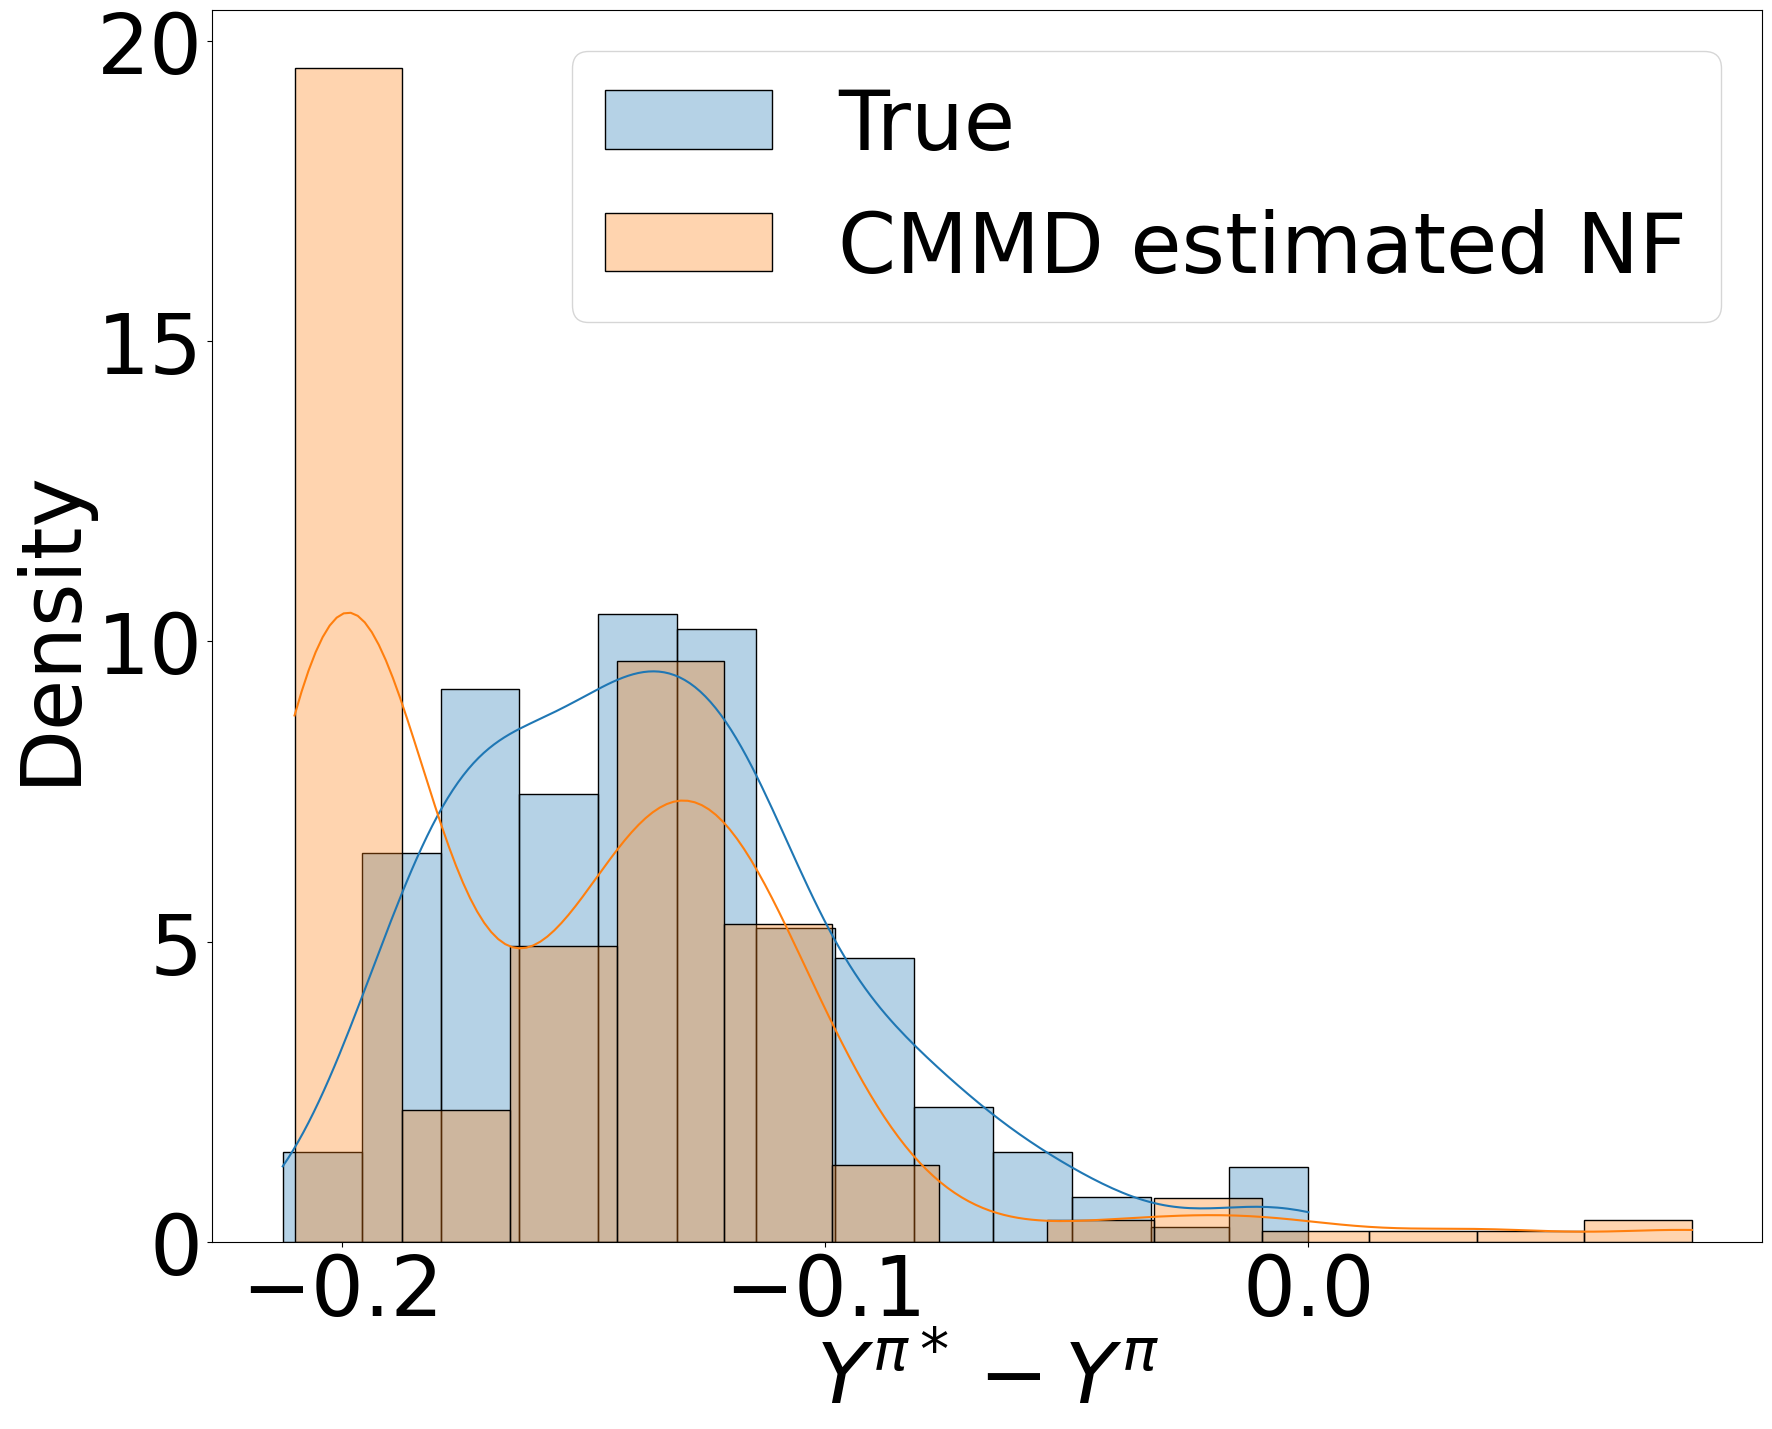

In [12]:
import seaborn as sns
fig, ax = plt.subplots()
sns.histplot(counterfactual_diffs[:], alpha=0.33, stat = "density", kde = True, label = "True")
sns.histplot(counterfactual_diffpreds[:], alpha=0.33, stat = "density", kde = True, label = "CMMD estimated NF")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
plt.legend()
fig.savefig("counterfactual_dist_bd_krcocycle")
plt.show()

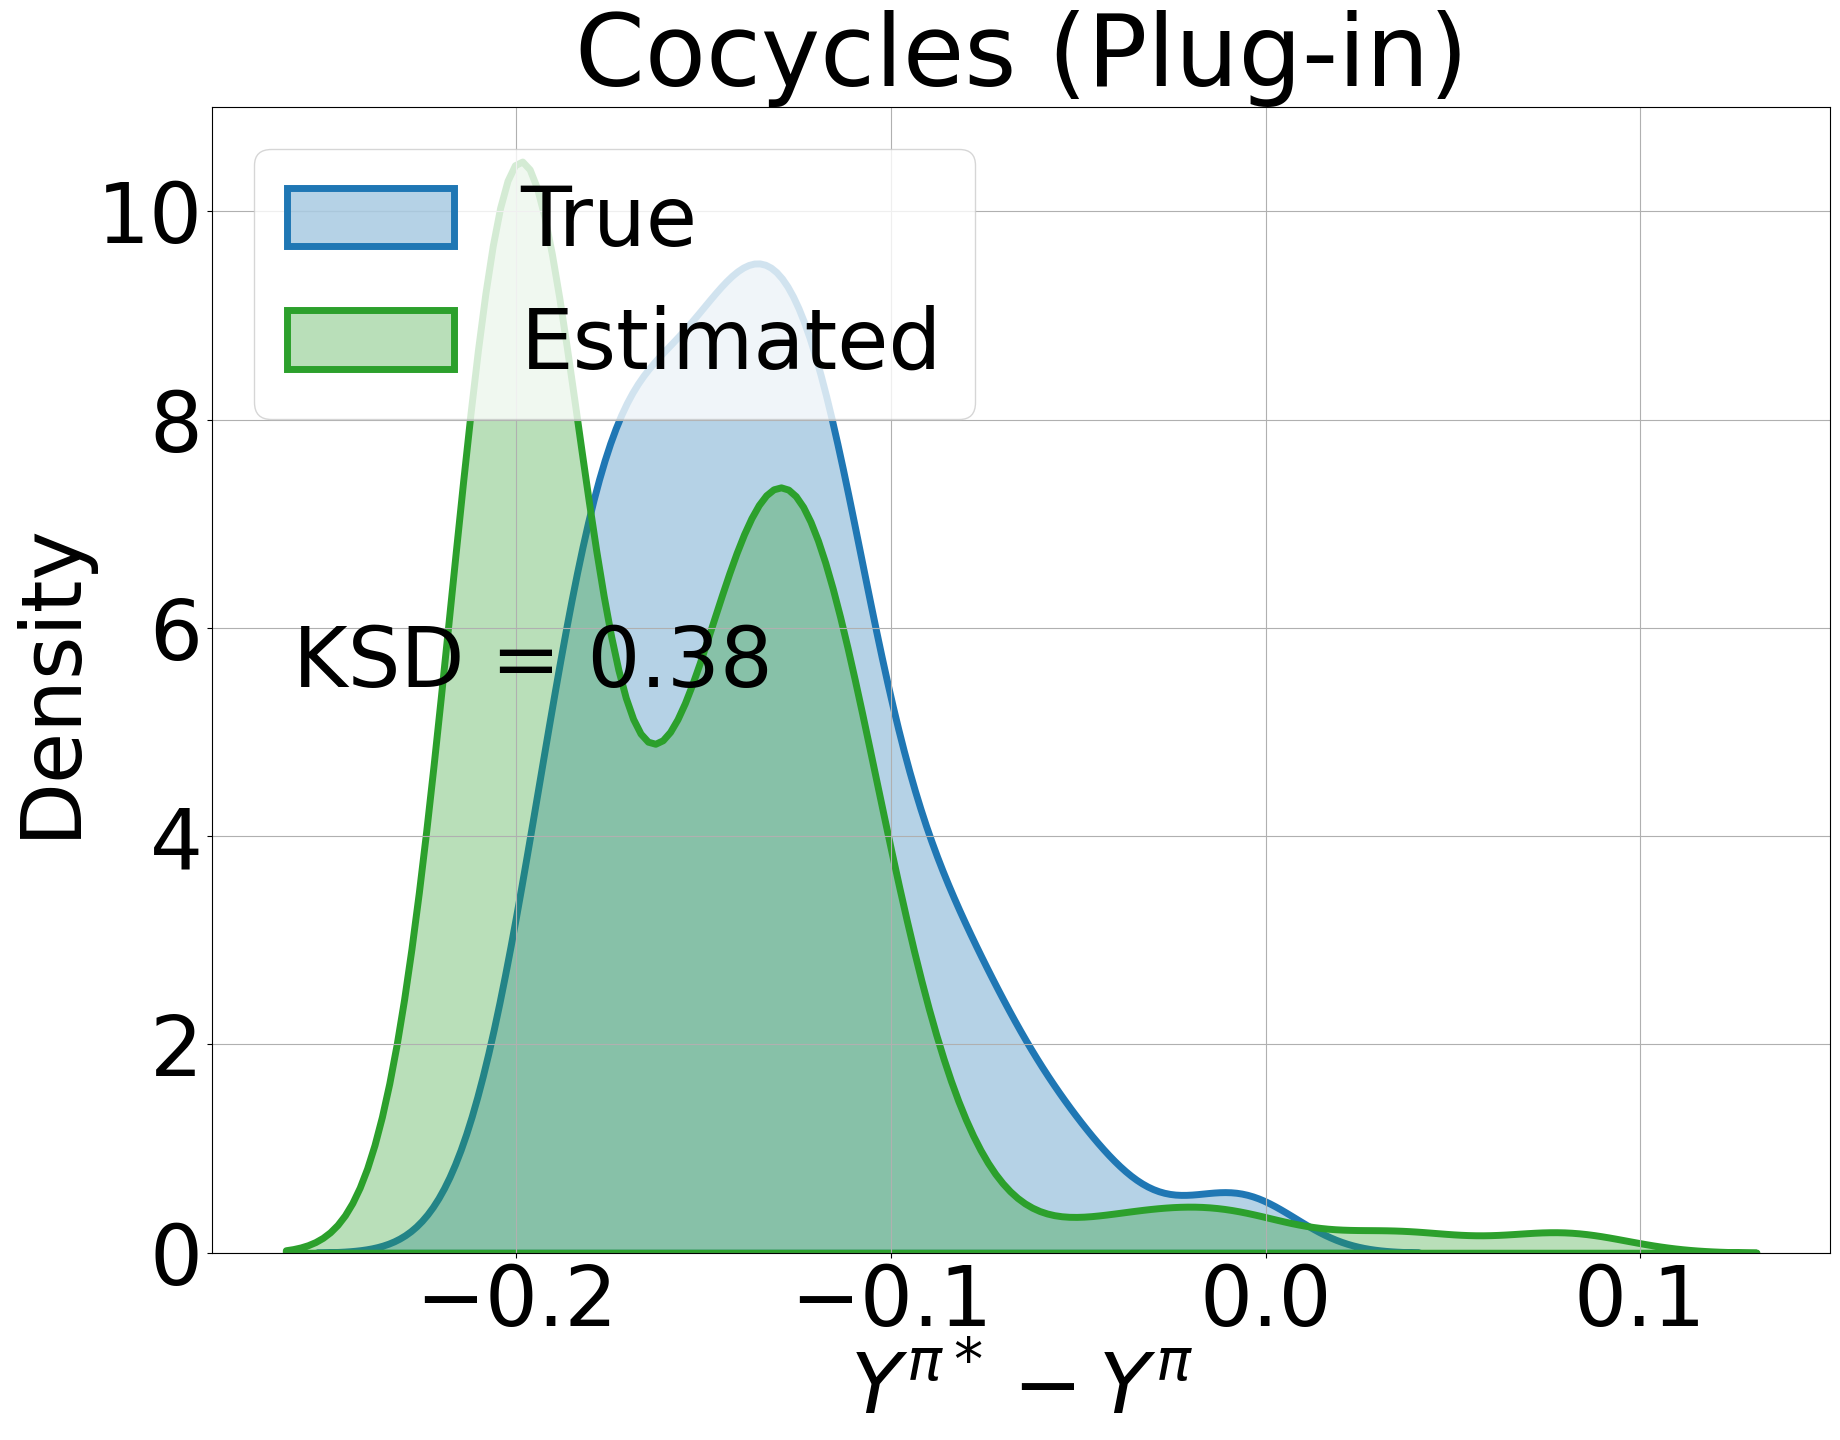

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Update matplotlib rcParams for higher font size and resolution
mpl.rcParams.update({
    'font.size': 60,         # Increase font size (default is usually 10)
    'figure.figsize': (20,16),  # Figure size remains the same as before
    'figure.dpi': 100        # Higher DPI for better fidelity
})

# Compute the KSD values
KSD = kolmogorov_distance(counterfactual_diffs, counterfactual_diffpreds)


# Second plot: Plug-in based estimator
fig, ax = plt.subplots()
sns.kdeplot(counterfactual_diffs[:], alpha=0.33, fill=True, ax=ax, label="True", lw = 5)
sns.kdeplot(counterfactual_diffpreds[:], alpha=0.33, fill=True, ax=ax, label="Estimated", color = "C2", lw = 5)
ax.set_title("Cocycles (Plug-in)")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
ax.legend(loc = "upper left")
# Add KSD label for the plug-in estimator
ax.text(0.05, 0.55, f"KSD = {KSD:.2f}", transform=ax.transAxes, verticalalignment='top')
plt.grid(True)
plt.tight_layout()
fig.savefig("Cocycle_BD_counterfactual_dist_pi_kr", bbox_inches = "tight")
plt.show()